In [3]:
#import plotting dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
#import analysis dependencies
import numpy as np
import pandas as pd
from scipy import stats

In [5]:
#import datetime dependency
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
#create connection engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

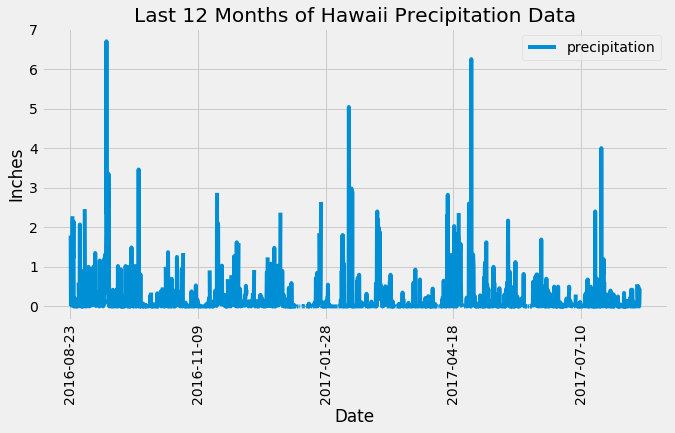

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#latest data point date:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# source: https://stackoverflow.com/questions/23324266/converting-string-to-date-object-without-time-info
#Create datetime object and then convert to date object
last_date_convert = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
last_date_convert = last_date_convert.date()

#calculating date 1 year before the last data point:
prev_yr_date = (last_date_convert - dt.timedelta(days = 365))

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_yr_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
#rename columns and set date to index
prcp_data_df = prcp_data_df.rename(columns = {'prcp':'precipitation', 'date':'Date'})
prcp_data_df.set_index(['Date'], inplace = True) 

# Sort the dataframe by date
#source: https://stackoverflow.com/questions/40262710/pandas-sorting-a-dataframe-by-using-datetimeindex
prcp_data_df = prcp_data_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot(figsize = (10,5))
plt.xticks(rotation = 'vertical')
plt.title("Last 12 Months of Hawaii Precipitation Data")
plt.ylabel("Inches")



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#source: https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).all()

#most active station
most_active_station = active_stations[0][0]

print(f"The most active station is {most_active_station}.")
active_stations


The most active station is USC00519281.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#lowest temp recorded for most active station
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
            filter(Measurement.station == most_active_station).all()

#highest temp recorded for most active station
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
            filter(Measurement.station == most_active_station).all()

#average temp recorded for most active station
average_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_station).all()

print(f"The lowest temperature recorded at {most_active_station} was {lowest_temp[0][1]}.")
print(f"The highest temperature recorded at {most_active_station} was {highest_temp[0][1]}.")
print(f"The average temperature recorded at {most_active_station} was {round(average_temp[0][1],2)}.")

The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66.


Text(0.5, 0, 'Temperature')

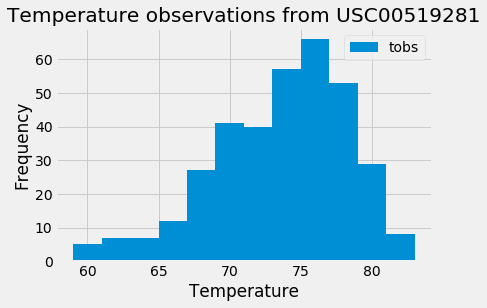

In [23]:
# Choose the station with the highest number of temperature observations.

#***found above in most_active_station query

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= prev_yr_date).\
            filter(Measurement.station == most_active_station).all()

# Save the query results as a Pandas DataFrame and plot histogram with 12 bins
temp_data_df = pd.DataFrame(temp_data)
temp_data_df.plot(kind = 'hist', bins = 12)
plt.title(f"Temperature observations from {most_active_station}")
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [24]:
#Temperature Analysis I

#Identify the average temperature in June at all stations 
#across all available years in the dataset. Do the same for December temperature.

#June
query_month_summer = '06'
average_temp_summer = session.query(func.avg(Measurement.tobs)).\
            group_by(Measurement.station).\
            filter(func.strftime("%m",Measurement.date)==query_month_summer).all()

summer_avg_list = list(np.ravel(average_temp_summer))

#December
query_month_winter = '12'
average_temp_winter = session.query(func.avg(Measurement.tobs)).\
            group_by(Measurement.station).\
            filter(func.strftime("%m",Measurement.date)==query_month_winter).all()

winter_avg_list = list(np.ravel(average_temp_winter))

#Use the t-test to determine whether the difference in the means, if any, is statistically significant.
#use paired test, since these are the same stations in the same locations, but a different time of the year
#source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
stats.ttest_rel(summer_avg_list,winter_avg_list)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

In [26]:
#Temperature Analysis II

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_results = calc_temps('2017-06-22','2017-07-01')
tmin = trip_results[0][0]
tmax = trip_results[0][2]
tavg = trip_results[0][1]


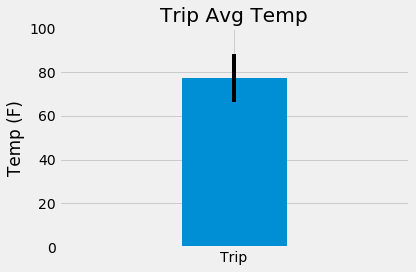

In [29]:
# Plot the results from your previous query as a bar chart. 

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = 'Trip'
plt.bar(x_axis,tavg, width = 3, yerr = tmax-tmin,align = 'center')

plt.ylim(0, 100)
plt.xlim(-5,5) 

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tight_layout()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#trip dates
trip_start = dt.date(2017,6,22)
trip_end = dt.date(2017,7,1)

#select data to show
sel = [Measurement.station, Station.name,func.sum(Measurement.prcp),Station.latitude, Station.longitude, Station.elevation]

#query for above selected data
#filter for trip dates
#group by stations to sum the prcp data
#order prcp sum in descending order
rainfall_per_station = session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= trip_start).\
        filter(Measurement.date<=trip_end).\
        group_by(Station.name).\
        order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_per_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  1.9800000000000002,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.7200000000000001,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  0.33999999999999997,
  21.4234,
  -157.8015,
  14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.16, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.12000000000000001,
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', 0.12, 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.0,
  21.5213,
  -157.8374,
  7.0)]

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
trip_start = dt.date(2017,6,22)
trip_end = dt.date(2017,7,1)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# source code: https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
trip_dates = []
delta = dt.timedelta(days=1)
while trip_start <= trip_end:
    trip_dates.append(trip_start.strftime("%m-%d"))
    trip_start += delta
    
# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`
normals = []

for date in trip_dates:
    day_normals = daily_normals(date)
    normals.append(day_normals[0])
normals

[(69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 81.0),
 (67.0, 74.77777777777777, 81.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns = ["Tmin", "Tavg", "Tmax"])
#add dates into dataframe
normals_df["Date"] = trip_dates
#reset index to date
normals_df.set_index("Date")


,Tmin,Tavg,Tmax
Date,,,
06-22,69.0,75.157895,81.0
06-23,68.0,74.543860,80.0
06-24,68.0,74.964286,84.0
06-25,68.0,74.103448,80.0
06-26,67.0,74.214286,82.0
06-27,66.0,75.017857,81.0
06-28,69.0,74.886792,80.0
06-29,67.0,74.915254,80.0
06-30,67.0,75.596154,81.0


Text(0.5, 1.0, 'Trip Daily Normals')

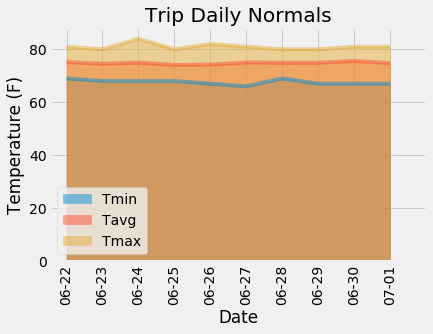

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind = 'area',stacked=False)
#rename x axis
x_locations = np.arange(0,11,1)
plt.xticks(x_locations, trip_dates, rotation = 'vertical')
#set titles and axis labels
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Trip Daily Normals")